# Load cleaned data

In [1]:
import glob
import json
import string
import math
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.model_selection import train_test_split
import random
random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# ========================= Columns =========================
gpt_sharing_columns = ['SharingURL', 'Status', 'DateOfConversation', 'DateOfAccess', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations']
commit_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message', 'AuthorAt', 'CommitAt'] + gpt_sharing_columns
code_file_columns = ['Type', 'URL', 'ObjectSha', 'FileName', 'FilePath', 'Author', 'Content', 'RepoName', 'RepoLanguage', 'CommitSha', 'CommitMessage', 'AuthorAt', 'CommitAt'] + gpt_sharing_columns
issue_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'State'] + gpt_sharing_columns
pull_request_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'CommitSha']  + gpt_sharing_columns
hacker_news_columns = ['Type', 'ID', 'URL', 'Author', 'Points', 'AttachedURL', 'Title', 'StoryText', 'CreatedAt', 'CommentsTotalCount'] + gpt_sharing_columns
discussion_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'Closed', 'UpvoteCount'] + gpt_sharing_columns
mention_columns = ['MentionedURL', 'MentionedProperty', 'MentionedAuthor', 'MentionedText', 'MentionedPath','MentionedAnswer', 'MentionedUpvoteCount'] + gpt_sharing_columns

# ========================= Processing functions =========================
def process_commit_json(commit):
    commit_array_of_elements = [commit[col] for col in commit_columns]
    return commit_array_of_elements

def process_code_files_json(code_file):
    code_files_array_of_elements = [code_file[col] for col in code_file_columns]
    return code_files_array_of_elements

def process_issue_json(issue):
    issue_array_of_elements = [issue[col] for col in issue_columns]
    return issue_array_of_elements

def process_pull_request_json(pull_request):
    pull_request_array_of_elements = [pull_request[col] for col in pull_request_columns]
    return pull_request_array_of_elements

def process_hacker_news_json(hacker_news):
    hacker_news_array_of_elements = [hacker_news[col] for col in hacker_news_columns]
    return hacker_news_array_of_elements

def process_discussion_json(discussion):
    discussion_array_of_elements = [discussion[col] for col in discussion_columns]
    return discussion_array_of_elements

In [3]:
def read_json_data_from_files_to_dataframe(json_filepath):
    file_sharings_df = pd.DataFrame()
    with open(json_filepath, 'r') as file:
        # Load JSON data from file
        json_data = json.load(file)
        data_to_df = []
        for source in json_data:
            source_array = []
            columns_for_df = []
            if source['Type'] == 'commit':
                source_array = process_commit_json(source)
                columns_for_df = commit_columns
            elif source['Type'] == 'code file':
                source_array = process_code_files_json(source)
                columns_for_df = code_file_columns
            elif source['Type'] == 'issue':
                source_array = process_issue_json(source)
                columns_for_df = issue_columns
            elif source['Type'] == 'pull request':
                source_array = process_pull_request_json(source)
                columns_for_df = pull_request_columns
            elif source['Type'] == 'hacker news':
                source_array = process_hacker_news_json(source)
                columns_for_df = hacker_news_columns
            elif source['Type'] == 'discussion':
                source_array = process_discussion_json(source)
                columns_for_df = discussion_columns
            else:
                print(f"Unexpected type of the course: '{source['Type']}'")
                raise
            data_to_df.append(source_array)
        file_dataframe = pd.DataFrame(data_to_df, columns=columns_for_df)
        file_sharings_df = pd.concat([file_sharings_df, file_dataframe])
    return file_sharings_df

In [4]:
cleaned_dir_name = "cleaned_datasets"
cleaned_dataframe_file_names = [f"{cleaned_dir_name}/cleaned_commits.json", f"{cleaned_dir_name}/cleaned_issues.json", f"{cleaned_dir_name}/cleaned_discussions.json", f"{cleaned_dir_name}/cleaned_pull_requests.json", f"{cleaned_dir_name}/cleaned_code_files.json", f"{cleaned_dir_name}/cleaned_hacker_news.json"]

dataframes_cleaned = []
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

for filename in cleaned_dataframe_file_names:
    dataframes_cleaned.append(read_json_data_from_files_to_dataframe(filename))

# Investigating the statistics after removing codelines

In [5]:
def count_conv_len_and_word_count(dataframe):
    dataframe_conversation_lengths, dataframe_conversation_lengths_for_avg, dataframe_prompt_lengths_sum, dataframe_prompt_wordcounts_sum = [], [], [], []
    for index, df_row in dataframe.iterrows():
        conversations = df_row.Conversations
        lengths = []
        conv_length = len(conversations)
        for conv_idx in range(len(conversations)):
            conversation = conversations[conv_idx]
            prompt = conversation["Prompt"]
            prompt_len = len(prompt)
            prompt_word_count = len(prompt.split())
            if len(dataframe_conversation_lengths_for_avg) <= conv_idx:
                dataframe_conversation_lengths_for_avg.append(1)
            else:
                dataframe_conversation_lengths_for_avg[conv_idx] += 1
            if len(dataframe_prompt_lengths_sum) <= conv_idx:
                dataframe_prompt_lengths_sum.append(prompt_len)
            else:
                dataframe_prompt_lengths_sum[conv_idx] += prompt_len
            if len(dataframe_prompt_wordcounts_sum) <= conv_idx:
                dataframe_prompt_wordcounts_sum.append(prompt_word_count)
            else:
                dataframe_prompt_wordcounts_sum[conv_idx] += prompt_word_count
        dataframe_conversation_lengths.append(conv_length)
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_lengths_sum))
    avg_prompt_lengths = [dataframe_prompt_lengths_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))]
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_wordcounts_sum))
    avg_prompt_word_counts = [dataframe_prompt_wordcounts_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))]
    conversation_count_per_conv_nr = np.zeros(max(dataframe_conversation_lengths))
    conv_len_dictionary = dict()
    for i in dataframe_conversation_lengths:
        conv_len_dictionary[i] = conv_len_dictionary.get(i, 0) + 1
        conversation_count_per_conv_nr[:i] += 1
    conv_len_dictionary = dict(sorted(conv_len_dictionary.items())) # Sort
    return conversation_count_per_conv_nr, conv_len_dictionary, avg_prompt_lengths, avg_prompt_word_counts

In [6]:
cleaned_conversation_count_per_conv_nr_list, cleaned_avg_prompt_lengths_list, cleaned_avg_prompt_word_count_list = [], [], []
for idx in range(len(dataframes_cleaned)):
    conversations_per_conv_nr, conv_dictionary, avg_prompt_lengths, avg_prompt_wc = count_conv_len_and_word_count(dataframes_cleaned[idx])
    cleaned_conversation_count_per_conv_nr_list.append(conversations_per_conv_nr)
    cleaned_avg_prompt_lengths_list.append(avg_prompt_lengths)
    cleaned_avg_prompt_word_count_list.append(avg_prompt_wc)
    print(f"Statistics for {dataframe_names[idx]} dataframe:")
    print("Dictionary containing the count of the lengths of the conversations: ", conv_dictionary)
    print("Average prompt lengths for each prompt: ", avg_prompt_lengths)
    print("Average word count for each prompt: ", avg_prompt_wc)
    print("=============================================================================")

Statistics for commits dataframe:
Dictionary containing the count of the lengths of the conversations:  {1: 509, 2: 53, 3: 34, 4: 16, 5: 5, 6: 5, 7: 6, 8: 1, 9: 5, 10: 3, 11: 3, 13: 2, 14: 2, 15: 2, 16: 2, 17: 1, 19: 2, 20: 1, 21: 1, 24: 2, 25: 1, 26: 2, 29: 1, 33: 1, 63: 1}
Average prompt lengths for each prompt:  [926.2904689863842, 180.98684210526315, 134.4747474747475, 117.23076923076923, 127.53061224489795, 133.38636363636363, 201.2051282051282, 199.57575757575756, 241.65625, 212.85185185185185, 181.08333333333334, 159.28571428571428, 201.66666666666666, 250.05263157894737, 213.1764705882353, 124.93333333333334, 182.23076923076923, 155.25, 125.25, 93.8, 100.66666666666667, 99.75, 153.375, 98.0, 94.0, 125.4, 153.33333333333334, 47.333333333333336, 120.33333333333333, 44.5, 24.5, 20.5, 32.5, 20.0, 39.0, 14.0, 28.0, 38.0, 12.0, 25.0, 10.0, 32.0, 32.0, 33.0, 14.0, 22.0, 21.0, 24.0, 24.0, 65.0, 62.0, 25.0, 18.0, 43.0, 168.0, 68.0, 30.0, 42.0, 139.0, 32.0, 52.0, 26.0, 51.0]
Average word

In [7]:
from statistics import mean, median, stdev
for idx in range(len(cleaned_conversation_count_per_conv_nr_list)):
    conversation_len_list = cleaned_conversation_count_per_conv_nr_list[idx]
    print(f"Statistics for {dataframe_names[idx]} dataframe:")
    print(f"Mean of the conversation length: {mean(conversation_len_list)}")
    print(f"Standard deviation of the conversation length: {stdev(conversation_len_list)}")
    print(f"Median of the conversation length: {median(conversation_len_list)}")
    print("=============================================================================")

Statistics for commits dataframe:
Mean of the conversation length: 23.11111111111111
Standard deviation of the conversation length: 85.42098992468574
Median of the conversation length: 2.0
Statistics for issues dataframe:
Mean of the conversation length: 21.66176470588235
Standard deviation of the conversation length: 59.43455206299518
Median of the conversation length: 3.0
Statistics for discussions dataframe:
Mean of the conversation length: 6.724137931034483
Standard deviation of the conversation length: 10.412549268359303
Median of the conversation length: 3.0
Statistics for pull requests dataframe:
Mean of the conversation length: 4.9156626506024095
Standard deviation of the conversation length: 19.868479571102664
Median of the conversation length: 1.0
Statistics for code files dataframe:
Mean of the conversation length: 22.63350785340314
Standard deviation of the conversation length: 100.53654170458724
Median of the conversation length: 5.0
Statistics for hacker news dataframe:
M

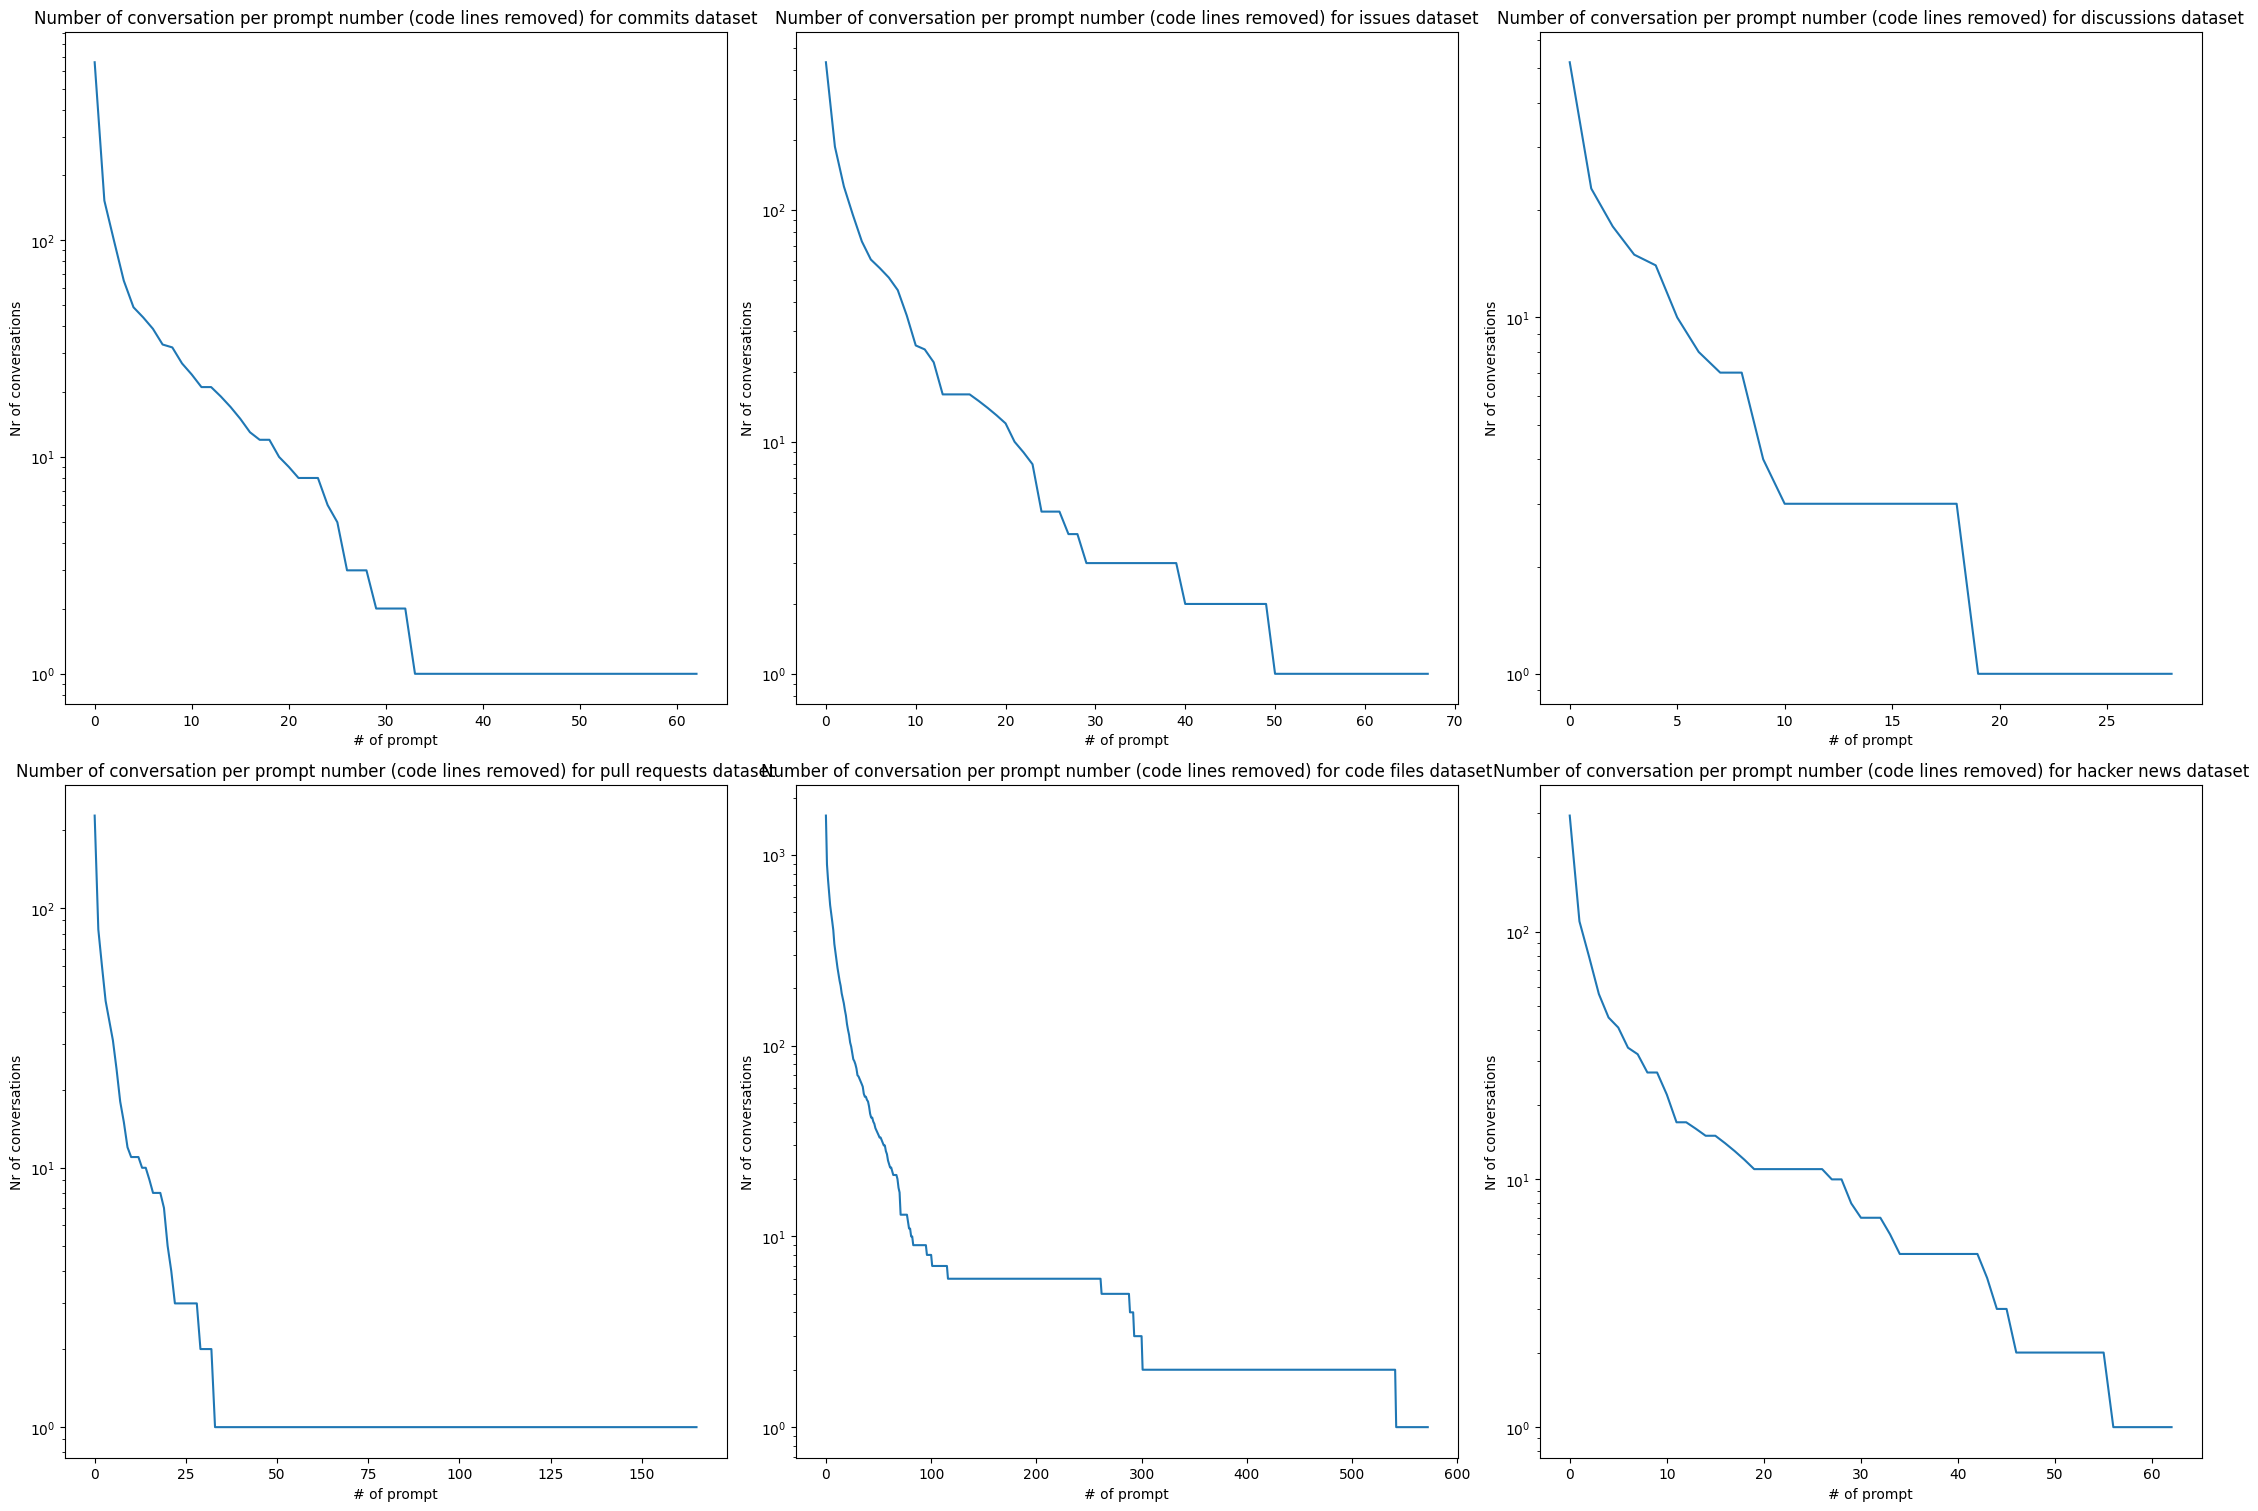

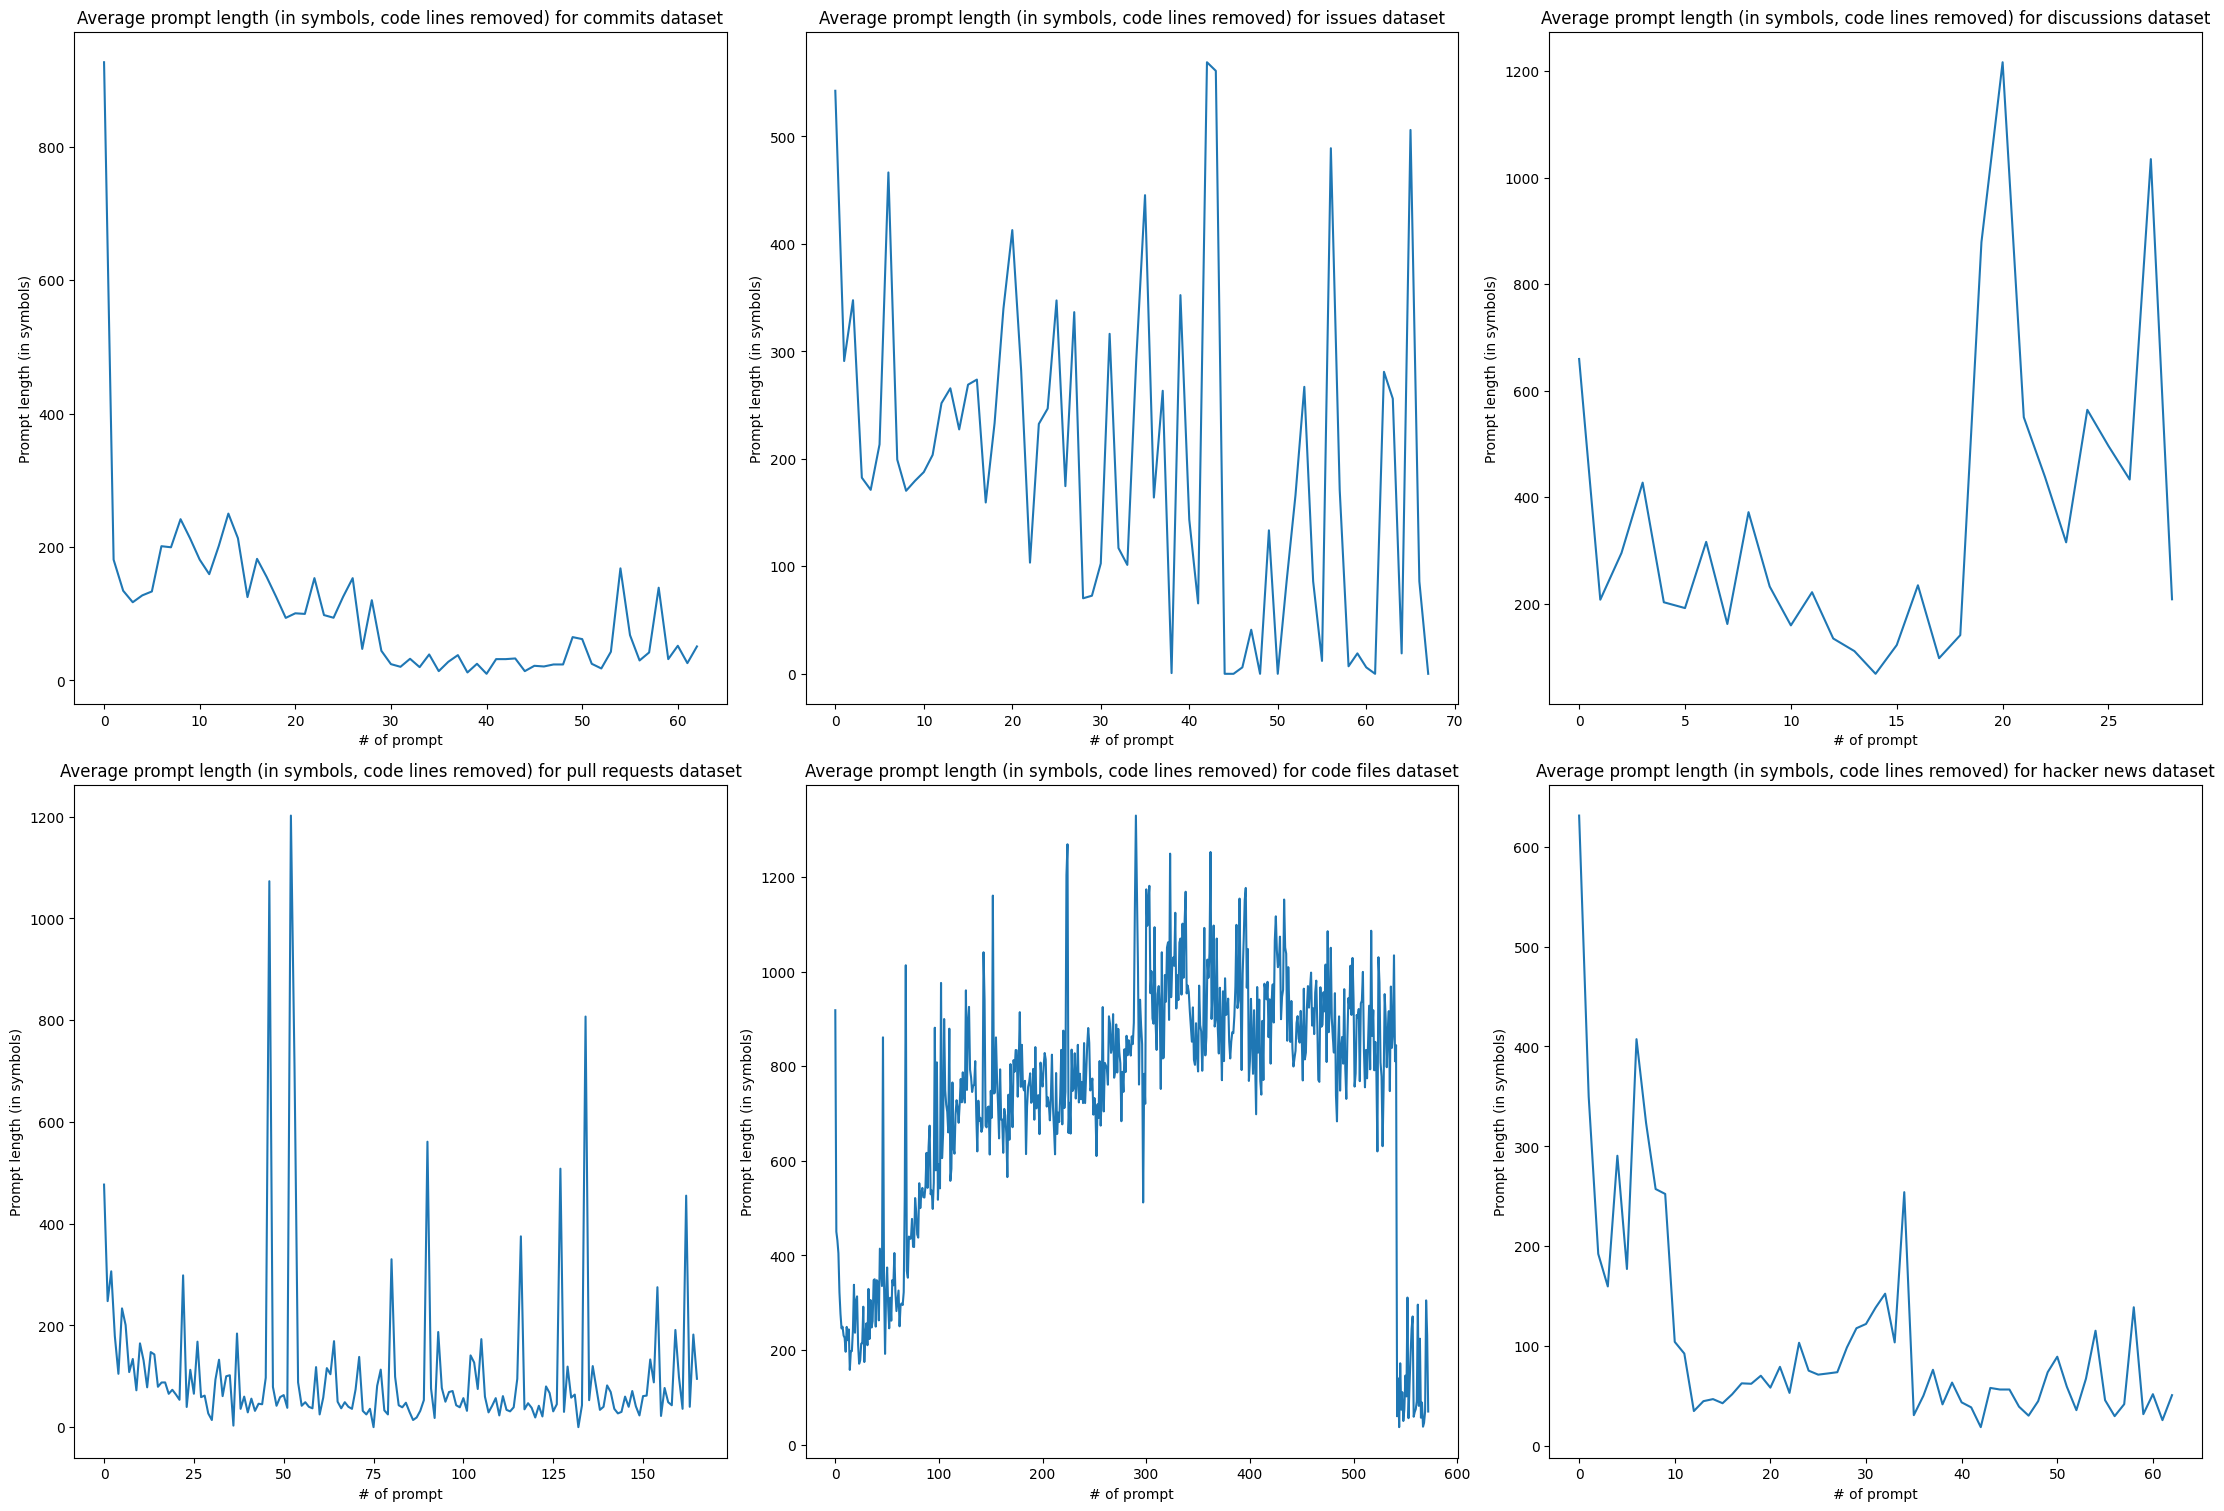

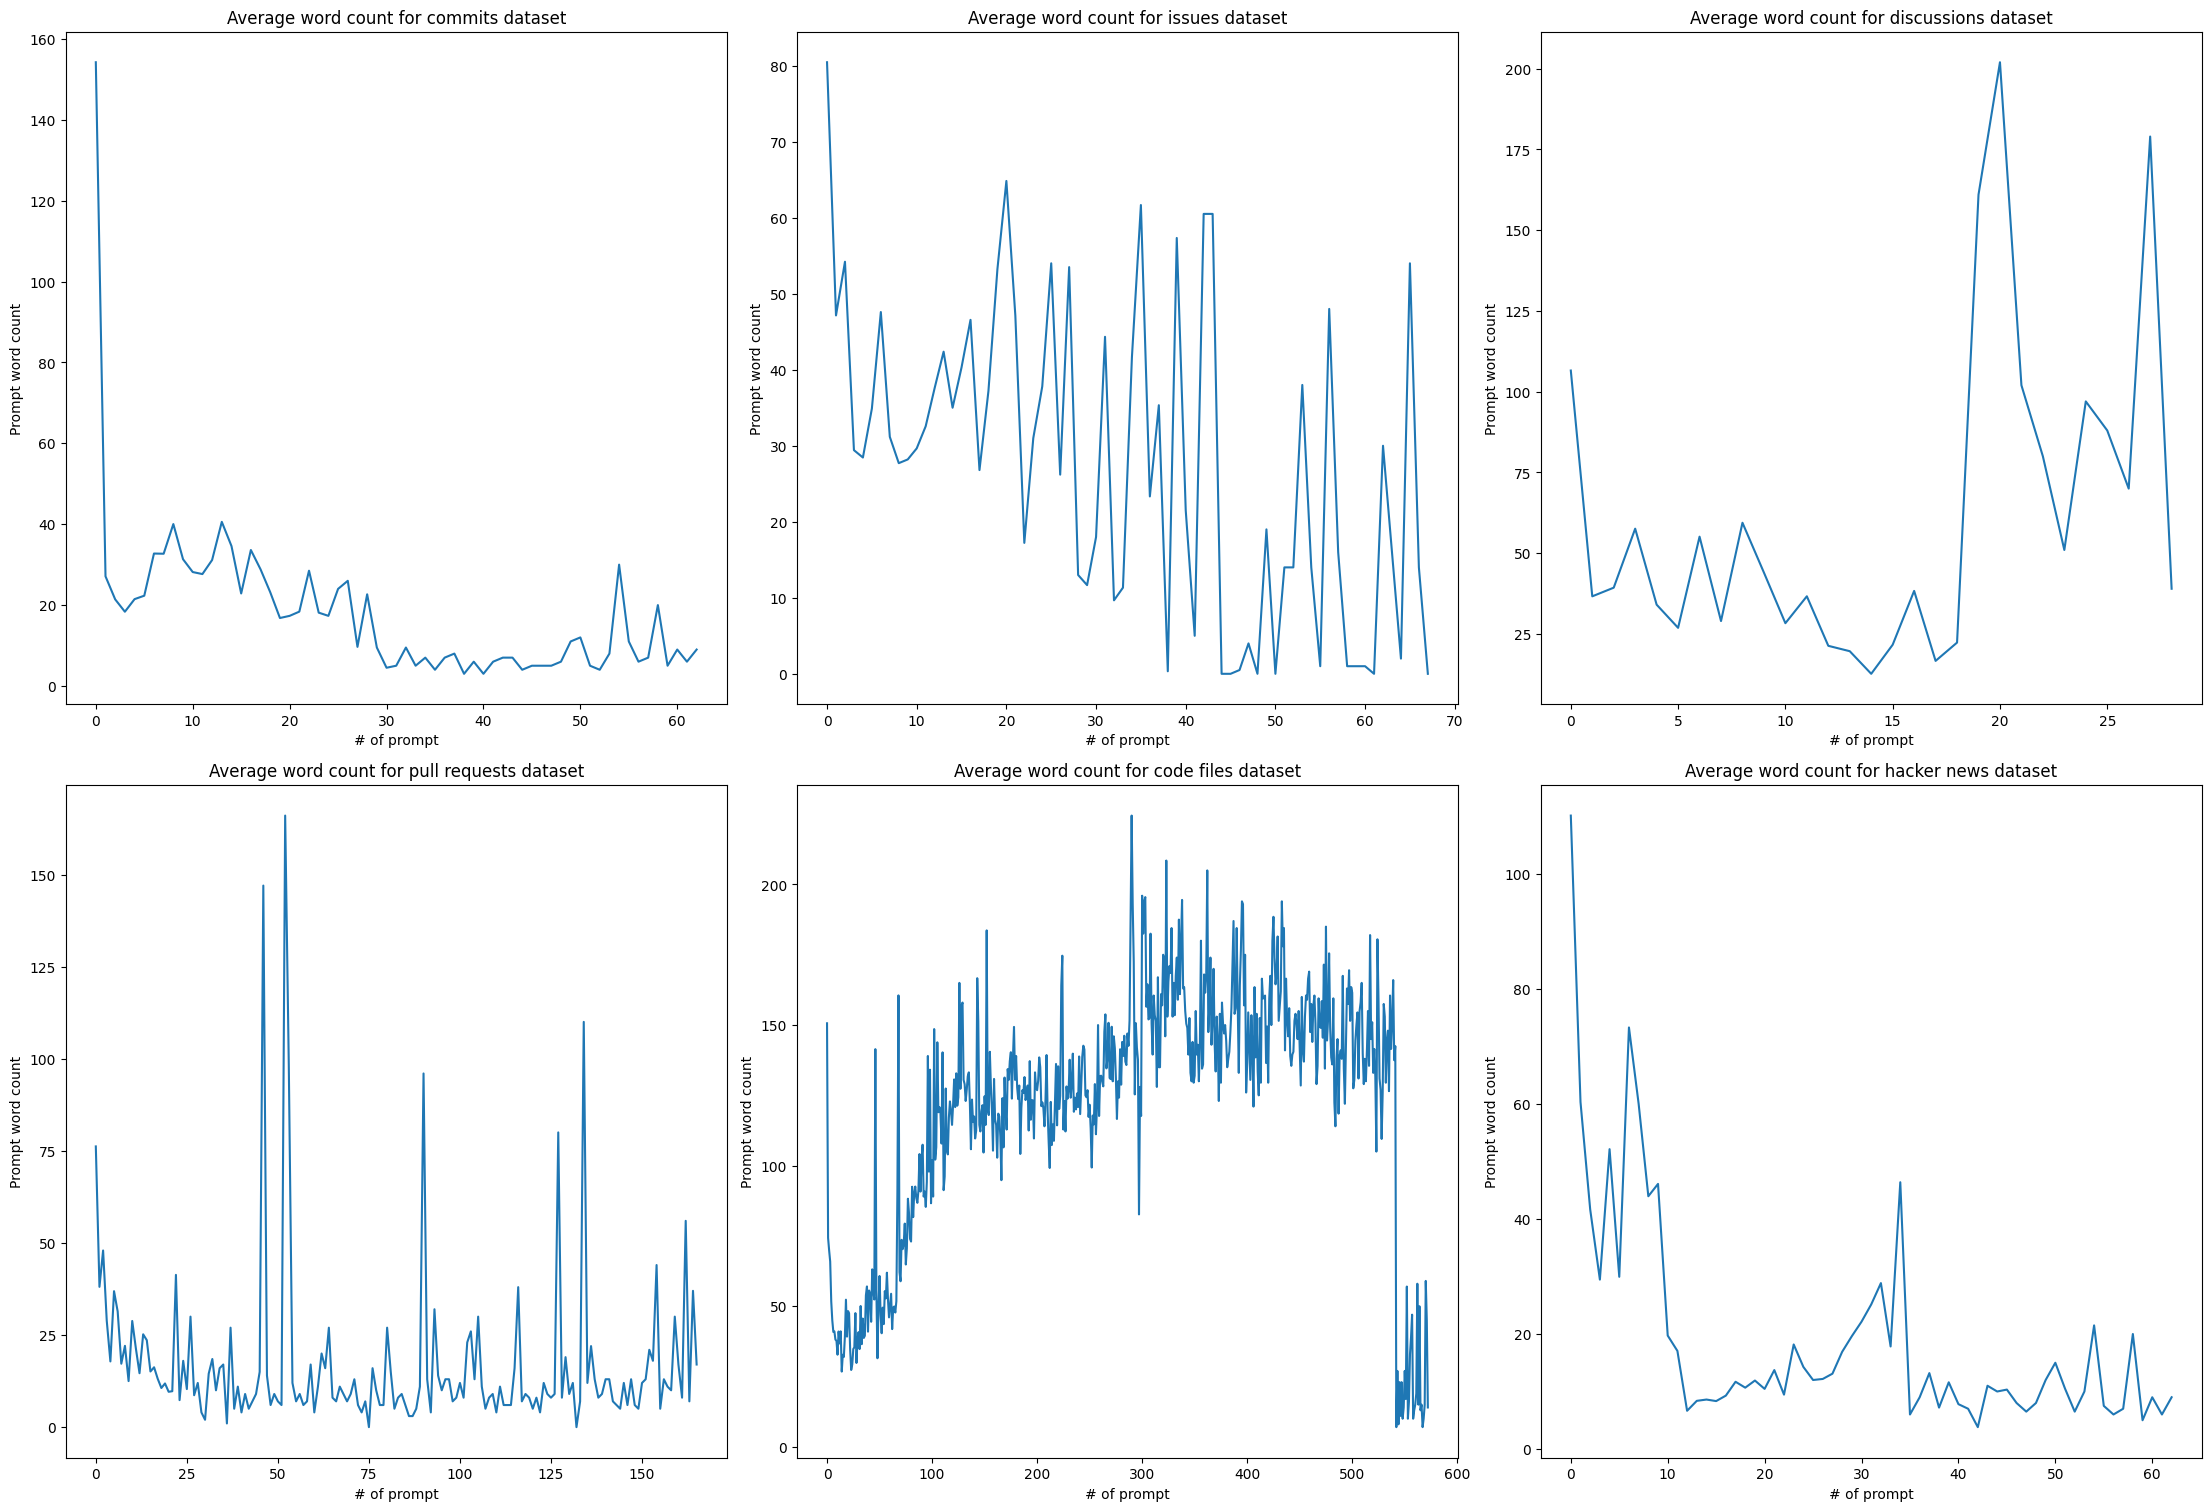

In [8]:
stats = [cleaned_conversation_count_per_conv_nr_list, cleaned_avg_prompt_lengths_list, cleaned_avg_prompt_word_count_list]
stats_titles = ["Number of conversation per prompt number (code lines removed)", "Average prompt length (in symbols, code lines removed)", "Average word count"]
stats_ylabels = ["Nr of conversations", "Prompt length (in symbols)", "Prompt word count"]

assert(len(stats) == len(stats_titles) == len(stats_ylabels))

for stat_idx, stat in enumerate(stats):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(22, 15), layout="constrained")
    plt.xlabel("Prompt number")
    plt.ylabel(f'{stats_ylabels[stat_idx]}')
    for idx in range(len(dataframes_cleaned)):
        i,j = int(not(idx<3)),idx % 3
        if stat_idx == 0:
            axs[i,j].set_yscale("log")
        axs[i,j].set_title(f'{stats_titles[stat_idx]} for {dataframe_names[idx]} dataset')
        axs[i,j].set_xlabel(f'# of prompt')
        axs[i,j].set_ylabel(stats_ylabels[stat_idx])
        axs[i,j].plot(stat[idx])
    plt.show()

### Investigate what do long conversations contain

In [11]:
long_conv_cutoff = [30, 30, 15, 30, 100, 50]
prompt_lengts_cutoff = [None, 400, 800, 800, 850, None]

too_long_conversations = {}
long_conv_filename = "./too_long_conversations.json"
too_long_prompts = {}
long_prompts_filename = "./too_long_prompts.json"

for df_idx in range(len(dataframes_cleaned)):
    for index, df_row in dataframes_cleaned[df_idx].iterrows():
        conversations = df_row.Conversations
        if len(conversations) >= long_conv_cutoff[df_idx]:
            too_long_conversations[df_row.URL] = []
            for conv in conversations:
                too_long_conversations[df_row.URL].append(conv["Prompt"])
        contains_too_long_prompts = False
        for conv_idx in range(len(conversations)):
            conversation = conversations[conv_idx]
            prompt = conversation["Prompt"]
            prompt_len = len(prompt)
            if prompt_lengts_cutoff[df_idx] != None and prompt_len >= prompt_lengts_cutoff[df_idx]:
                contains_too_long_prompts = True
                break
        if contains_too_long_prompts:
            too_long_prompts[df_row.URL] = []
            for conv in conversations:
                too_long_prompts[df_row.URL].append(conv["Prompt"])


with open(long_conv_filename, 'w') as file:
        json.dump(too_long_conversations, file)

with open(long_prompts_filename, 'w') as file:
        json.dump(too_long_prompts, file)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



{'Prompt': 'What is "alignment tax" in reference to when tuning large language models for safety', 'Answer': 'ChatGPT"Alignment tax" is a term used in AI safety research, specifically in the context of aligning large language models such as GPT-4 with human values and intents. The "tax" refers to the costs or disadvantages that come from trying to make an AI system more aligned with human values.This might include the following:Training Costs: Making an AI system safe often requires additional resources, such as more training data, computational resources, or time. This could involve techniques like reinforcement learning from human feedback, where additional data needs to be gathered, or more complicated architecture designs.Performance Trade-offs: In some cases, making an AI system safer might involve limiting its capabilities in certain respects. For example, certain unsafe or unethical behaviours might be reduced at the cost of limiting the system\'s creativity or versatility. This